In [201]:
import os
import glob
import math
import time
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import scipy as sc
from sklearn.model_selection import KFold
import lightgbm as lgb
import warnings
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import random
import seaborn as sns; sns.set_theme()
import torch.nn.functional as F
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
import statsmodels.api as sm
import pylab as pl
from matplotlib.pyplot import figure
from IPython import display
from pandas.plotting import scatter_matrix
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import umap
from sklearn import svm
from lightgbm import LGBMClassifier
from numpy import std
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from matplotlib import cm
from sklearn.metrics import confusion_matrix

In [202]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [203]:
warnings.filterwarnings('ignore')
pd.set_option('max_columns', 300)

In [204]:
train_test_seurat = pd.read_csv('./integrate.csv')

In [205]:
train_test_seurat = train_test_seurat.T

In [206]:
train_test_seurat_std = train_test_seurat.std()
column_names = list(train_test_seurat.columns)
columns_remove = []
for i in range(train_test_seurat.shape[1]):
    if train_test_seurat_std[i] == 0:
        columns_remove.append(column_names[i])

In [207]:
train_test_seurat = train_test_seurat.drop(columns_remove, axis=1)

In [208]:
train_test_seurat[columns_remove[0]] = train_test_seurat.iloc[:, 0]

In [209]:
clusters = pd.read_csv('./clusters.csv')
train_test_seurat['class'] = clusters

In [210]:
train = pd.read_csv('./MLR_Project_train.csv')
test = pd.read_csv('./MLR_Project_test.csv')

target = pd.DataFrame(pd.concat([train['TARGET'], test['TARGET']]))
target = target.rename(index=lambda s: 'Sample' + str(int(s)+1))

train_test_seurat['TARGET'] = 1.0

for i in range(train_test_seurat.shape[0]):
    train_test_seurat['TARGET'][i] = target['TARGET'][i]

In [211]:
train_test_seurat

,X39,X53,X45,X13,X36,X15,X51,X49,X33,X40,X31,X34,X32,X50,X30,X18,X46,X35,X37,X17,X42,X38,X43,X47,X0,X52,X48,X41,X2,X3,X25,X23,X9,X27,X14,X19,X24,X16,X29,X26,X28,X21,X1,X11,X20,X22,X5,X4,X6,X12,X7,X10,X8,X62,class,TARGET
Sample1,-1.582156,1.230171,2.175619,2.246967,-0.755876,3.583055,0.098955,3.040176,0.919099,-0.889421,0.484578,0.481170,0.777112,-1.798247,0.873301,2.270459,2.912388,0.728549,-1.295910,2.275724,-0.359744,-0.363988,-0.717875,2.265473,1.019072,0.721157,2.260484,-1.834228,2.254474,2.254450,3.042155,2.259637,2.946272,2.258885,3.401480,3.345012,2.937407,3.343820,2.935077,2.941428,2.259203,2.938547,2.469231,2.945955,3.044228,2.259368,3.073369,2.943574,2.945749,2.259507,2.259501,3.071520,2.259504,-1.582156,7,0.013314
Sample2,-1.584404,1.605045,-2.204271,2.227963,-0.760217,3.535377,0.300338,2.880602,0.943713,-0.890453,0.513255,0.509388,0.803151,-1.042563,0.900408,2.251683,2.831043,0.757081,-1.302729,2.256918,-0.368216,-0.372547,-0.725350,2.242051,1.084322,1.273463,2.239054,-1.836103,2.235786,2.235849,2.995526,2.240825,2.901227,2.240080,3.359956,3.304083,2.898066,3.302884,2.895731,2.902085,2.240400,2.910457,2.446440,2.903884,3.007216,2.240566,3.004351,2.907020,2.906517,2.240683,2.240706,3.025257,2.240732,-1.584404,7,-0.000448
Sample3,-1.594548,1.172960,2.547328,2.138920,-0.779797,3.321969,-0.241806,2.693446,0.934271,-0.895068,0.505998,0.502247,0.793162,-1.196648,0.893682,2.165409,2.656538,0.750002,-1.334065,2.170502,-0.407147,-0.411875,-0.759699,2.150257,0.909735,0.858274,2.152557,-1.844565,2.150014,2.149977,2.786986,2.154385,2.734335,2.153668,3.172415,3.119236,2.720591,3.118004,2.718235,2.724605,2.154003,2.731983,2.340769,2.729945,2.798645,2.154173,2.832534,2.727687,2.728807,2.154322,2.154294,2.816114,2.154304,-1.594548,7,0.000244
Sample4,-1.540117,1.471016,-1.464351,2.589700,-0.674728,4.499712,-0.070470,3.630669,-0.163725,-0.869522,0.771819,0.763805,1.057894,-1.013944,1.144550,2.601021,3.586176,1.014063,-1.175844,2.588606,-0.210578,-0.213300,-0.586264,2.586420,1.452937,1.030784,2.588699,-1.799160,2.583419,2.583483,3.941371,2.590836,3.676733,2.589976,4.174776,4.107204,3.672950,4.106144,3.670702,3.676991,2.590239,3.685219,2.879247,3.681201,3.949020,2.590387,3.953846,3.682269,3.681686,2.590519,2.590540,3.971859,2.590523,-1.540117,7,-0.000628
Sample5,-1.601161,1.122772,2.557003,2.079653,-0.792563,3.184293,0.169903,2.380626,0.968678,-0.898042,0.546909,0.542502,0.829559,-1.363513,-0.469419,2.107699,2.530198,0.790754,-1.355026,2.112698,-0.433188,-0.438182,-0.782676,2.091026,0.925432,0.645674,2.091058,-1.850081,2.092565,2.092535,2.652600,2.096564,2.618092,2.095867,2.443792,2.998522,2.604873,2.997269,2.602504,2.608884,2.096211,2.615890,2.270373,2.613631,2.663541,2.096384,2.693932,2.611509,2.613064,2.096538,2.096525,2.682193,2.096533,-1.601161,7,0.003811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample109703,-1.811006,-2.112556,-0.131305,-1.445311,-1.197634,-0.818321,-1.049270,-1.122315,-0.508777,-0.357198,1.027011,-0.311548,0.721451,-2.989994,0.889711,-1.483919,-1.102665,-0.136718,0.872560,-1.485440,0.397786,-2.070832,0.489914,-1.491222,-4.525414,-2.391811,-1.488305,0.216442,-1.483623,-1.483645,-1.030355,-1.481442,-1.076202,-1.483214,-1.062814,-1.047183,-1.082408,-1.057290,-1.070795,-1.077186,-1.483106,-1.077155,-1.348169,-1.074557,-1.005825,-1.483853,-0.998264,-1.075246,-1.074719,-1.483446,-1.483451,-1.000564,-1.483459,-1.811006,4,0.000061
Sample109704,0.753172,-1.087454,-0.172401,-0.671626,0.416608,-0.605980,-0.603986,-0.787102,1.405494,-0.960323,0.122744,1.482535,0.217549,-1.818208,-0.006719,-0.725304,-0.736942,1.349400,0.214743,-0.727687,-1.691140,0.832361,-1.892583,-0.731506,-3.272527,-1.266335,-0.731930,0.941092,-0.720566,-0.720532,-0.645284,-0.724744,-0.706717,-0.723241,-0.704043,-0.710849,-0.699841,-0.697351,-0.719490,-0.712830,-0.725970

In [212]:
train_seurat = train_test_seurat.iloc[:90000, :]
test_seurfat = train_test_seurat.iloc[90000:, :]

In [213]:
pca = PCA(n_components=2)
pca.fit(train_seurat.iloc[:, :-2])
print(pca.explained_variance_ratio_)
train_pca = pca.fit_transform(train_seurat.iloc[:, :-2])
reducer = umap.UMAP()
train_umap = reducer.fit_transform(train_seurat.iloc[:, :-2])

[0.64043368 0.09965526]


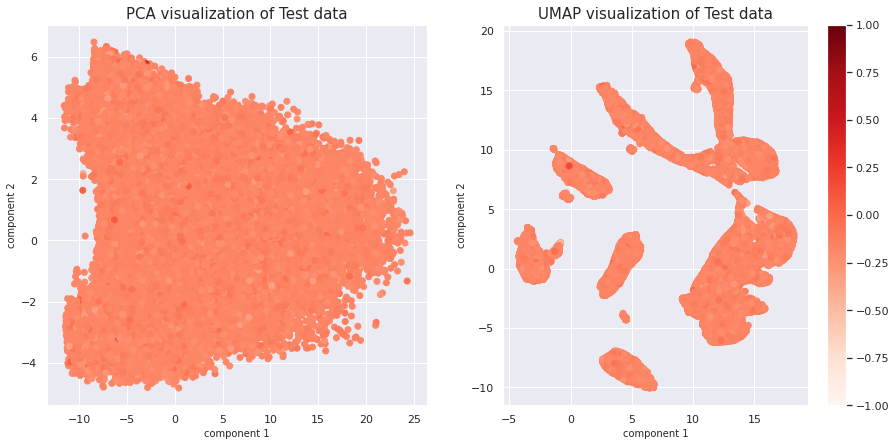

In [214]:
new_inferno = cm.get_cmap('inferno', 5)

figure, ax = plt.subplots(1, 2, figsize = (15, 7))

color_map = (train_seurat['TARGET'] - np.min(train_seurat['TARGET'])) / (np.max(train_seurat['TARGET']) - np.min(train_seurat['TARGET']))*2-1

# ax.scatter(train_pca[:, 0], train_pca[:, 1], c=np.sign(train['TARGET']), cmap=matplotlib.colors.ListedColormap(colors))
im_0 = ax[0].scatter(train_pca[:, 0], train_pca[:, 1], c=color_map, cmap='Reds', alpha = 1)
im_1 = ax[1].scatter(train_umap[:, 0], train_umap[:, 1], c=color_map, cmap='Reds', alpha = 1)

ax[0].set_title('PCA visualization of Test data', fontsize=15)
ax[0].set_xlabel('component 1', fontsize=10)
ax[0].set_ylabel('component 2', fontsize=10)

ax[1].set_title('UMAP visualization of Test data', fontsize=15)
ax[1].set_xlabel('component 1', fontsize=10)
ax[1].set_ylabel('component 2', fontsize=10)
plt.colorbar(im_1)
plt.show()

In [215]:
train_seurat['group'] = 1.0

quantiles = [train_seurat['TARGET'].quantile(x/10) for x in range(1, 10)]
quantiles

[-0.0082320012,
 -0.0027611330000000003,
 -0.0011282369,
 -0.00039890240000000005,
 1.66e-06,
 0.00040506600000000004,
 0.0011242414,
 0.0027775565999999985,
 0.008175773]

In [216]:
for i in range(train_seurat.shape[0]):
    for j in range(9):
        if train_seurat['TARGET'][i] < quantiles[j]:
            train_seurat['group'][i] = j
            break
        train_seurat['group'][i] = 9

In [217]:
train_seurat

,X39,X53,X45,X13,X36,X15,X51,X49,X33,X40,X31,X34,X32,X50,X30,X18,X46,X35,X37,X17,X42,X38,X43,X47,X0,X52,X48,X41,X2,X3,X25,X23,X9,X27,X14,X19,X24,X16,X29,X26,X28,X21,X1,X11,X20,X22,X5,X4,X6,X12,X7,X10,X8,X62,class,TARGET,group
Sample1,-1.582156,1.230171,2.175619,2.246967,-0.755876,3.583055,0.098955,3.040176,0.919099,-0.889421,0.484578,0.481170,0.777112,-1.798247,0.873301,2.270459,2.912388,0.728549,-1.295910,2.275724,-0.359744,-0.363988,-0.717875,2.265473,1.019072,0.721157,2.260484,-1.834228,2.254474,2.254450,3.042155,2.259637,2.946272,2.258885,3.401480,3.345012,2.937407,3.343820,2.935077,2.941428,2.259203,2.938547,2.469231,2.945955,3.044228,2.259368,3.073369,2.943574,2.945749,2.259507,2.259501,3.071520,2.259504,-1.582156,7,0.013314,9.0
Sample2,-1.584404,1.605045,-2.204271,2.227963,-0.760217,3.535377,0.300338,2.880602,0.943713,-0.890453,0.513255,0.509388,0.803151,-1.042563,0.900408,2.251683,2.831043,0.757081,-1.302729,2.256918,-0.368216,-0.372547,-0.725350,2.242051,1.084322,1.273463,2.239054,-1.836103,2.235786,2.235849,2.995526,2.240825,2.901227,2.240080,3.359956,3.304083,2.898066,3.302884,2.895731,2.902085,2.240400,2.910457,2.446440,2.903884,3.007216,2.240566,3.004351,2.907020,2.906517,2.240683,2.240706,3.025257,2.240732,-1.584404,7,-0.000448,3.0
Sample3,-1.594548,1.172960,2.547328,2.138920,-0.779797,3.321969,-0.241806,2.693446,0.934271,-0.895068,0.505998,0.502247,0.793162,-1.196648,0.893682,2.165409,2.656538,0.750002,-1.334065,2.170502,-0.407147,-0.411875,-0.759699,2.150257,0.909735,0.858274,2.152557,-1.844565,2.150014,2.149977,2.786986,2.154385,2.734335,2.153668,3.172415,3.119236,2.720591,3.118004,2.718235,2.724605,2.154003,2.731983,2.340769,2.729945,2.798645,2.154173,2.832534,2.727687,2.728807,2.154322,2.154294,2.816114,2.154304,-1.594548,7,0.000244,5.0
Sample4,-1.540117,1.471016,-1.464351,2.589700,-0.674728,4.499712,-0.070470,3.630669,-0.163725,-0.869522,0.771819,0.763805,1.057894,-1.013944,1.144550,2.601021,3.586176,1.014063,-1.175844,2.588606,-0.210578,-0.213300,-0.586264,2.586420,1.452937,1.030784,2.588699,-1.799160,2.583419,2.583483,3.941371,2.590836,3.676733,2.589976,4.174776,4.107204,3.672950,4.106144,3.670702,3.676991,2.590239,3.685219,2.879247,3.681201,3.949020,2.590387,3.953846,3.682269,3.681686,2.590519,2.590540,3.971859,2.590523,-1.540117,7,-0.000628,3.0
Sample5,-1.601161,1.122772,2.557003,2.079653,-0.792563,3.184293,0.169903,2.380626,0.968678,-0.898042,0.546909,0.542502,0.829559,-1.363513,-0.469419,2.107699,2.530198,0.790754,-1.355026,2.112698,-0.433188,-0.438182,-0.782676,2.091026,0.925432,0.645674,2.091058,-1.850081,2.092565,2.092535,2.652600,2.096564,2.618092,2.095867,2.443792,2.998522,2.604873,2.997269,2.602504,2.608884,2.096211,2.615890,2.270373,2.613631,2.663541,2.096384,2.693932,2.611509,2.613064,2.096538,2.096525,2.682193,2.096533,-1.601161,7,0.003811,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample89996,0.103760,-0.323209,-0.033912,0.504407,0.932129,-0.098634,-0.687340,0.052372,0.175746,-0.657793,-1.040164,-0.270910,-0.719094,-0.871932,-0.530427,0.405426,0.159104,-0.021451,0.626506,0.407638,1.068273,0.466155,0.542083,0.404342,0.637946,-0.699337,0.402187,1.206836,0.403753,0.403796,0.111838,0.409407,0.165668,0.412404,0.118302,0.112101,0.166753,0.107222,0.167445,0.164019,0.409890,0.160662,0.327742,0.165710,0.112724,0.409590,0.121034,0.165462,0.165721,0.409705,0.409703,0.115440,0.409704,0.103760,2,0.001185,7.0
Sample89997,0.270911,-1.178868,-0.215649,-0.526271,-0.831779,-0.589190,-0.853648,-0.699739,-0.942459,-0.612974,-0.772829,-1.455120,-0.514554,-1.595189,-0.289078,-0.589598,-0.636953,-1.152731,1.088975,-0.589015,0.058042,0.642626,-0.349257,-0.591799,-0.636469,-1.493630,-0.593950,0.298781,-0.592508,-0.592574,-0.619011,-0.584295,-0.627197,-0.587219,-0.635496,-0.635929,-0.626819,-0.635882,-0.631618,-0.629097,-0.5866

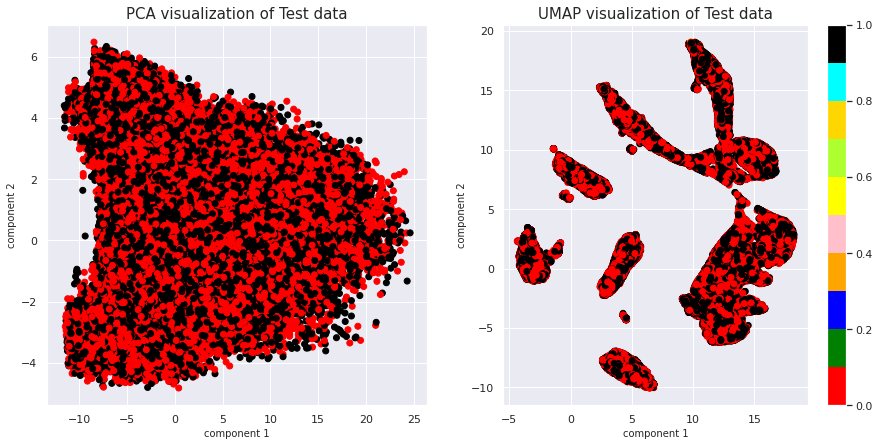

In [218]:
colors = ['red', 'green', 'blue', 'orange', 'pink', 'yellow', 'greenyellow', 'gold', 'cyan', 'black']

new_inferno = cm.get_cmap('inferno', 5)

figure, ax = plt.subplots(1, 2, figsize = (15, 7))

color_map = (train_seurat['TARGET'] - np.min(train_seurat['TARGET'])) / (np.max(train_seurat['TARGET']) - np.min(train_seurat['TARGET']))*2-1

im_0 = ax[0].scatter(train_pca[:, 0], train_pca[:, 1], c=(np.sign(train_seurat['TARGET'])+1)/2, cmap=matplotlib.colors.ListedColormap(colors))
# im_0 = ax[0].scatter(train_pca[:, 0], train_pca[:, 1], c=color_map, cmap='Reds', alpha = 1)
im_1 = ax[1].scatter(train_umap[:, 0], train_umap[:, 1], c=(np.sign(train_seurat['TARGET'])+1)/2, cmap=matplotlib.colors.ListedColormap(colors))

ax[0].set_title('PCA visualization of Test data', fontsize=15)
ax[0].set_xlabel('component 1', fontsize=10)
ax[0].set_ylabel('component 2', fontsize=10)

ax[1].set_title('UMAP visualization of Test data', fontsize=15)
ax[1].set_xlabel('component 1', fontsize=10)
ax[1].set_ylabel('component 2', fontsize=10)
plt.colorbar(im_1)
plt.show()

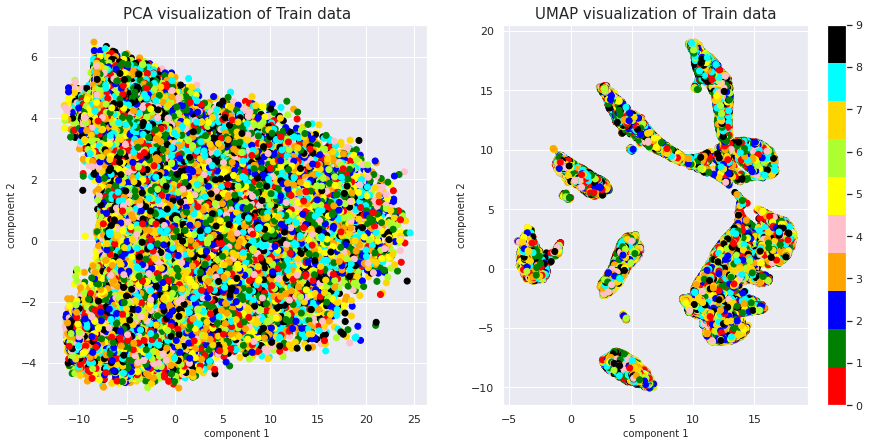

In [219]:
colors = ['red', 'green', 'blue', 'orange', 'pink', 'yellow', 'greenyellow', 'gold', 'cyan', 'black']

new_inferno = cm.get_cmap('inferno', 5)

figure, ax = plt.subplots(1, 2, figsize = (15, 7))

im_0 = ax[0].scatter(train_pca[:, 0], train_pca[:, 1], c=train_seurat['group'], cmap=matplotlib.colors.ListedColormap(colors))
im_1 = ax[1].scatter(train_umap[:, 0], train_umap[:, 1], c=train_seurat['group'], cmap=matplotlib.colors.ListedColormap(colors))

ax[0].set_title('PCA visualization of Train data', fontsize=15)
ax[0].set_xlabel('component 1', fontsize=10)
ax[0].set_ylabel('component 2', fontsize=10)

ax[1].set_title('UMAP visualization of Train data', fontsize=15)
ax[1].set_xlabel('component 1', fontsize=10)
ax[1].set_ylabel('component 2', fontsize=10)
plt.colorbar(im_1)
plt.show()

## 1.3 Show the maximum return of train and test

In [14]:
train_max = np.sum(train['TARGET'][train['TARGET']>0])
test_max = np.sum(test['TARGET'][test['TARGET']>0])

print('Maximum return of training set:', train_max)
print('Maximum return of testing set:', test_max)

Maximum return of training set: 195.6927566509
Maximum return of testing set: 55.96225182400002


In [15]:
reg = Ridge(alpha=0.5).fit(pd.DataFrame(train_seurat.iloc[:, :]), train['TARGET'])
pred = reg.predict(pd.DataFrame(train_seurat.iloc[:, :]))

pred_test = reg.predict(pd.DataFrame(test_seurat.iloc[:, :]))

train_res = np.sum(train['TARGET'][pred>0])
test_res = np.sum(test['TARGET'][pred_test>0])

In [16]:
print(f'Train naive random selection percentage return: {train_res/train_max*100}%')
print(f'Test naive random selection percentage return: {test_res/test_max*100}%')

Train naive random selection percentage return: 6.32652526152815%
Test naive random selection percentage return: 4.010962118285209%


### 1.3.1 Remove the Unnamed columns in dataframe

In [17]:
train = train.loc[:, ~train.columns.str.contains('^Unnamed')]
test = test.loc[:, ~test.columns.str.contains('^Unnamed')]

## 1.4 Naive random selection experiment

In [18]:
train_random = 0
for j in range(10000):
    ind = np.random.randint(2, size=train.shape[0])
    train_random = train_random + sum(train['TARGET'][ind>0])

print('Result of train naive random selection:', train_random/10000)

test_random = 0
for j in range(10000):
    ind = np.random.randint(2, size=test.shape[0])
    test_random = test_random + sum(test['TARGET'][ind>0])

print('Result of test naive random selection:', test_random/10000)


Result of train naive random selection: -0.8170112755425528
Result of test naive random selection: -0.6496402211191966


In [19]:
print(f'Train naive random selection percentage return: {(train_random/10000)/train_max*100}%')
print(f'Test naive random selection percentage return: {(test_random/10000)/test_max*100}%')

Train naive random selection percentage return: -0.41749694241368096%
Test naive random selection percentage return: -1.1608543258092974%


## 1.5 Get data shape

In [20]:
# print('Train shape:', train.shape)
# print('Test shape:', test.shape)

## 3.1 Remove extreme Target values

In [21]:
# train = train.sort_values(by=['TARGET'])
# # remove samples with extreme large target values and samples with extreme negative values
# num_remove = 10
# train_remove = train.iloc[num_remove:-num_remove, :]
# # train.shape

## 3.2 Remove extreme features values

In [22]:
# for i in range(train.shape[1]-1):
#     train_remove = train_remove.sort_values(by=[str(i)])
#     num_remove = 5
#     train_remove = train_remove.iloc[num_remove:-num_remove, :]

In [23]:
# train_remove.shape

In [24]:
# figure, ax = plt.subplots(1, 1, figsize = (35, 7))

# train_remove_mean_values = train_remove.mean()
# train_remove_std_values = train_remove.std()

# train_remove_std = (train_remove-train_remove.mean())/train_remove.std()

# # train_remove_std.boxplot()
# # ax.set_xlabel('Features', fontsize=20)
# ax.set_ylabel('Values', fontsize=20)
# ax.set_title('Train standardized features variability', fontsize=25)

# figure.savefig("features_std_dis.png", bbox_inches='tight', dpi=600)

### The devil is in the details, we need to standardize test dataset by using train mean and train standard deviation

In [25]:
# test_std = (test-train_remove_mean_values)/train_remove_std_values

## 5.5 Autoencoder Resnet model

In [27]:
input_features = train_seurat.to_numpy()
output_features = pd.DataFrame(train['TARGET']).to_numpy()

#######
for i in range(input_features.shape[0]):
    input_features[i, :] = (input_features[i, :] - np.mean(input_features[i, :]))/np.std(input_features[i, :])
#######

input_ = np.zeros((input_features.shape[0], 9, 6))
output_ = np.zeros((output_features.shape[0], 9, 6))

for i in range(input_.shape[0]):
    input_[i, :, :] = np.reshape(input_features[i, :], (9, 6))
    
input_features = input_
    
# input_features = torch.tensor(input_features, 1)

X_test = test_seurat.to_numpy()
Y_test = pd.DataFrame(test['TARGET']).to_numpy()

#######
for i in range(X_test.shape[0]):
    X_test[i, :] = (X_test[i, :] - np.mean(X_test[i, :]))/np.std(X_test[i, :])
#######


X_test_ = np.zeros((X_test.shape[0], 9, 6))
for i in range(X_test_.shape[0]):
    X_test_[i, :, :] = np.reshape(X_test[i, :], (9, 6))
X_test = X_test_
    
X_train, X_val, Y_train, Y_val = train_test_split(input_features, output_features, test_size=0.2, random_state=42)

#####
# to calculate returns
train_data, val_data = train_test_split(train, test_size=0.2, random_state=42)
test_data = test
#####

auto_train_max = np.sum(train_data['TARGET'][train_data['TARGET']>0])
auto_val_max = np.sum(val_data['TARGET'][val_data['TARGET']>0])
auto_test_max = np.sum(test['TARGET'][test['TARGET']>0])

print('Train X shape:', X_train.shape)
print('Validation X shape:', X_val.shape)
print('Test X shape:', X_test.shape)

print('Train Y shape:', Y_train.shape)
print('Val Y shape:', Y_val.shape)
print('Test Y shape:', Y_test.shape)

print('train_max:', auto_train_max)
print('val_max:', auto_val_max)
print('test_max:', auto_test_max)

Train X shape: (72000, 9, 6)
Validation X shape: (18000, 9, 6)
Test X shape: (19707, 9, 6)
Train Y shape: (72000, 1)
Val Y shape: (18000, 1)
Test Y shape: (19707, 1)
train_max: 156.45405680890002
val_max: 39.238699842
test_max: 55.96225182400002


In [28]:
train_input = torch.from_numpy(X_train)
train_output = torch.from_numpy(Y_train)
val_input = torch.from_numpy(X_val)
val_output = torch.from_numpy(Y_val)
test_input = torch.from_numpy(X_test)
test_output = torch.from_numpy(Y_test)

train_input = torch.unsqueeze(train_input, 1)
val_input = torch.unsqueeze(val_input, 1)
test_input = torch.unsqueeze(test_input, 1)

train_input = train_input.float()
train_output = train_output.float()
val_input = val_input.float()
val_output = val_output.float()
test_input = test_input.float()
test_output = test_output.float()

input_feature = train_input.shape[1]
output_feature = 1

# print('input_feature:', input_feature)
# print('output_feature:', output_feature)

In [29]:
train_input = train_input.to(device)
train_output = train_output.to(device)
val_input = val_input.to(device)
val_output = val_output.to(device)
test_input = test_input.to(device)
test_output = test_output.to(device)

In [30]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

In [35]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 2)
        self.conv2 = nn.Conv2d(16, 32, 2)
        self.maxpool = nn.MaxPool2d(2)
        
        self.linear = nn.Linear(96, 1)
        
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//16)
        self.linear4 = nn.Linear(input_feature//16, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, input_feature//16)
        self.linear6 = nn.Linear(input_feature//16+input_feature, input_feature//16)
        
        self.batchnorm_1 = nn.BatchNorm1d(input_feature//2)
        self.batchnorm_2 = nn.BatchNorm1d(input_feature//4)
        self.batchnorm_3 = nn.BatchNorm1d(input_feature//16)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.15)
        
        self.softmax = nn.Softmax()
        

    def forward(self, x_):
        x = self.conv1(x_)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = torch.flatten(x, 1)
        x = self.relu(x)
        output = self.linear(x)
        return output.float()

In [36]:
batch_size = 100000
train_ds = TensorDataset(train_input, train_output)
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=False)

In [37]:
%matplotlib inline
def fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output, model_path):
    best_loss = float('inf')
    train_pred_output = []
    val_pred_output = []
    train_error = []
    val_error = []
    test_error = []
    epochs = []
    
    train_returns = []
    val_returns = []
    test_returns = []
    
    train_sum = []
    val_sum = []
    test_sum = []

    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            opt.zero_grad()
            pred = model(x)
            y = torch.reshape(y, (y.shape[0], 1))
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()

        if epoch % 50 == 0:
            
            model = model.eval()
            
            train_pred = model(train_input)
            train_pred_index = (torch.sign(train_pred)+1)//2
            train_output = torch.reshape(train_output, (train_output.shape[0], 1))
            train_loss = loss_fn(train_output, train_pred)
            # train_loss = loss_fn(train_pred, train_output.long().squeeze())
            train_loss = train_loss.cpu().detach().numpy()
            
            val_pred = model(val_input)
            val_pred_index = (torch.sign(val_pred)+1)//2
            val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            val_loss = loss_fn(val_output, val_pred)
            # val_loss = loss_fn(val_pred, val_output.long().squeeze())
            val_loss = val_loss.cpu().detach().numpy()
        
            test_pred = model(test_input)
            test_pred_index = (torch.sign(test_pred)+1)//2
            test_output = torch.reshape(test_output, (test_output.shape[0], 1))
            test_loss = loss_fn(test_output, test_pred)
            # test_loss = loss_fn(test_pred, test_output.long().squeeze())
            test_loss = test_loss.cpu().detach().numpy()
    
            epochs.append(epoch)
            train_error.append(math.log(train_loss+1))
            val_error.append(math.log(val_loss+1))
            test_error.append(math.log(test_loss+1))
            
#             figure, ax = plt.subplots(1, 2, figsize = (20, 7))
#             ax = ax.flatten()
            
#             figure, ax = plt.subplots(1, 4, figsize = (22, 5))
#             ax = ax.flatten()
            
#             plt.grid(False)
            # train_conf = confusion_matrix(train_output, train_pred_index)
#             g1 = sns.heatmap(train_conf, cmap="YlGnBu",cbar=False, ax=ax[0], annot = True)
#             g1.set_ylabel('True Target')
#             g1.set_xlabel('Predict Target')
#             g1.set_title('Train dataset')

#             plt.grid(False)
            # val_conf = confusion_matrix(val_output, val_pred_index)
#             g2 = sns.heatmap(val_conf, cmap="YlGnBu",cbar=False, ax=ax[1], annot = True)
#             g2.set_ylabel('True Target')
#             g2.set_xlabel('Predict Target')
#             g2.set_title('Val dataset')
            
#             plt.grid(False)
            # test_conf = confusion_matrix(test_output, test_pred_index)
#             g3 = sns.heatmap(test_conf, cmap="YlGnBu",cbar=False, ax=ax[2], annot = True)
#             g3.set_ylabel('True Target')
#             g3.set_xlabel('Predict Target')
#             g3.set_title('Test dataset')
            
            train_pred_np = train_pred_index.cpu().detach().numpy()
            train_output_np = train_output.cpu().detach().numpy()
            val_pred_np = val_pred_index.cpu().detach().numpy()
            val_output_np = val_output.cpu().detach().numpy()
            test_pred_np = test_pred_index.cpu().detach().numpy()
            test_output_np = test_output.cpu().detach().numpy()
            
#             train_max_value = max(max(train_output_np), max(train_pred_np))
#             train_min_value = min(min(train_output_np), min(train_pred_np))
#             val_max_value = max(max(val_output_np), max(val_pred_np))
#             val_min_value = min(min(val_output_np), min(val_pred_np))
#             test_max_value = max(max(test_output_np), max(test_pred_np))
#             test_min_value = min(min(test_output_np), min(test_pred_np))
            
#             ax[0].scatter(train_output_np, train_pred_np, s = 20, alpha=0.3, c='blue')
#             ax[1].scatter(val_output_np, val_pred_np, s = 20, alpha=0.3, c='red')
#             ax[2].scatter(test_output_np, test_pred_np, s = 20, alpha=0.3, c='green')
            
#             ax[0].plot(epochs, train_error, c='blue')
#             ax[0].plot(epochs, val_error, c='red')
#             ax[0].plot(epochs, test_error, c='green')
#             ax[0].set_title('Errors vs Epochs', fontsize=15)
#             ax[0].set_xlabel('Epoch', fontsize=10)
#             ax[0].set_ylabel('Errors', fontsize=10)

#             ax[0].legend(['train', 'valid', 'test'])
            
#             ax[0].set_xlim([train_min_value, train_max_value])
#             ax[0].set_ylim([train_min_value, train_max_value])
#             ax[0].set_title('Trainig data', fontsize=15)
#             ax[0].set_xlabel('Target', fontsize=10)
#             ax[0].set_ylabel('Prediction', fontsize=10)
#             ax[0].plot([train_min_value, train_max_value], [train_min_value, train_max_value], 'k-')
            
#             ax[1].set_xlim([val_min_value, val_max_value])
#             ax[1].set_ylim([val_min_value, val_max_value])
#             ax[1].set_title('Validation data', fontsize=15)
#             ax[1].set_xlabel('Target', fontsize=10)
#             ax[1].set_ylabel('Prediction', fontsize=10)
#             ax[1].plot([val_min_value, val_max_value], [val_min_value, val_max_value], 'k-')
            
#             ax[2].set_xlim([test_min_value, test_max_value])
#             ax[2].set_ylim([test_min_value, test_max_value])
#             ax[2].set_title('Testing data', fontsize=15)
#             ax[2].set_xlabel('Target', fontsize=10)
#             ax[2].set_ylabel('Prediction', fontsize=10)
#             ax[2].plot([test_min_value, test_max_value], [test_min_value, test_max_value], 'k-')
            
#             ax[3].plot(epochs, train_error, c='blue')
#             ax[3].plot(epochs, val_error, c='red')
#             ax[3].plot(epochs, test_error, c='green')
#             ax[3].set_title('Training and Validation error', fontsize=15)
#             ax[3].set_xlabel('Epochs', fontsize=10)
#             ax[3].set_ylabel('MSE error', fontsize=10)
            
#             display.clear_output(wait=True)
#             display.display(pl.gcf())
            
#             print('Epoch ', epoch, 'Train_loss: ', train_loss*1000, ' Validation_loss: ', val_loss*100, ' Test_loss: ', test_loss*100)
            # print(train_pred_np.shape, train_pred_np)
            # print(train_pred, train_pred_np)
            train_pred_np = np.squeeze(train_pred_np)
            val_pred_np = np.squeeze(val_pred_np)
            test_pred_np = np.squeeze(test_pred_np)
            
            train_res = np.sum(train_data['TARGET'][train_pred_np>0])
            train_output_check = np.squeeze(train_output_np)
            train_check = np.sum(train_data['TARGET'][train_output_check>0])
            
            val_res = np.sum(val_data['TARGET'][val_pred_np>0])
            val_output_check = np.squeeze(val_output_np)
            val_check = np.sum(val_data['TARGET'][val_output_check>0])
            
            test_res = np.sum(test_data['TARGET'][test_pred_np>0])
            test_output_check = np.squeeze(test_output_np)
            test_check = np.sum(test_data['TARGET'][test_output_check>0])
            
#             train_returns.append(train_res)
#             val_returns.append(val_res)
#             test_returns.append(test_res)
            
#             ax[1].plot(epochs, train_returns, c='blu`e')
#             ax[1].plot(epochs, val_returns, c='red')
#             ax[1].plot(epochs, test_returns, c='green')
#             ax[1].legend(['train', 'valid', 'test'])
#             ax[1].set_title('Return vs Epochs', fontsize=15)
#             ax[1].set_xlabel('Epoch', fontsize=10)
#             ax[1].set_ylabel('Returns', fontsize=10)

#             display.clear_output(wait=True)
#             display.display(pl.gcf())
            
            train_sum.append(train_res)
            val_sum.append(val_res)
            test_sum.append(test_res)
            # print(f'Checks: {train_check/auto_train_max*100}%, {val_check/auto_val_max*100}%, {test_check/auto_test_max*100}%')
#             print(f'Maximum sum train return {train_res}, Total train return: {auto_train_max}, Maximum train percentage return: {train_res/auto_train_max*100}%')
#             print(f'Maximum sum train return {val_res}, Total train return: {auto_val_max}, Maximum train percentage return: {val_res/auto_val_max*100}%')
#             print(f'Maximum sum test return {test_res}, Total test return: {auto_test_max}, Maximum test percentage return: {test_res/auto_test_max*100}%')
#             print('Epoch:', epoch, 'Train loss:', train_loss, 'Val loss:', val_loss, 'Test loss:', test_loss)
            print(f'Epoch: {epoch}, Train loss: {train_loss}, Train return: {train_res/auto_train_max*100}%, Val loss: {val_loss}, Val return: {val_res/auto_val_max*100}%, Test loss: {test_loss}, Test return: {test_res/auto_test_max*100}%')
        
            if val_loss < best_loss:
                torch.save(model.state_dict(), model_path)
                best_loss = val_loss
                
#             train_pred_output.append([train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy()])
#             val_pred_output.append([val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()])
    return train_sum, val_sum, test_sum


In [ ]:
num_epochs = 20000
learning_rate = 0.001
loss_fn = F.mse_loss
# loss_fn = nn.CrossEntropyLoss()

seed_everything()

model = Autoencoder()
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_sum_1, val_sum_1, test_sum_1, train_conf_1, val_conf_1, test_conf_1 = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output, 'model_path_cnn')
# fig.savefig("auto_encoder.png", bbox_inches='tight', dpi=600)

Epoch: 0, Train loss: 0.00842222385108471, Train return: -0.6734364015162209%, Val loss: 0.008379928767681122, Val return: -0.7255568205531266%, Test loss: 0.008193804882466793, Test return: -0.9211383123416649%
Epoch: 50, Train loss: 0.004782435018569231, Train return: -1.6590978959213156%, Val loss: 0.004779001232236624, Val return: -2.0249661181421565%, Test loss: 0.004752246662974358, Test return: 0.6427081492917412%
Epoch: 100, Train loss: 0.0033749272115528584, Train return: -1.4823133729492781%, Val loss: 0.0033766848500818014, Val return: -2.027651507832037%, Test loss: 0.0033532101660966873, Test return: 0.6526274141874032%
Epoch: 150, Train loss: 0.002630552975460887, Train return: -1.4579789081379864%, Val loss: 0.002631840528920293, Val return: -1.7021610774297176%, Test loss: 0.002607585396617651, Test return: 0.6699481771732899%
Epoch: 200, Train loss: 0.002166937105357647, Train return: -1.3340090258888442%, Val loss: 0.002166402991861105, Val return: -1.587414426339595%

In [ ]:
# model = Autoencoder_model()
# model.load_state_dict(torch.load(model_path))
# model.eval()